In [10]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Finding new Rfam families only

In [11]:
%autoreload
from rna2d.utils import Rfam

rfam142 = "../external-files/rfam-14.2/Rfam.pdb"
rfam148 = "../external-files/rfam-14.8/Rfam.pdb"

rfam = Rfam()
rfam2_mapping = rfam.get_pdb_family_mapping(rfam142)
rfam8_mapping = rfam.get_pdb_family_mapping(rfam148)
print(len(rfam2_mapping), len(rfam8_mapping))

5736 7659


In [12]:
%autoreload
rfam2_ids = set(rfam.get_families_ids(rfam142))
rfam8_ids = set(rfam.get_families_ids(rfam148))

a = rfam2_ids.difference(rfam8_ids)
b = rfam8_ids.difference(rfam2_ids)
i = rfam2_ids.intersection(rfam8_ids)

print(len(rfam2_ids), len(rfam8_ids))
print(f'2vs8: {len(a)}, 8vs2:{len(b)}, intersection:{len(i)}')
print(b)

rfam8_fams = rfam.get_pdb_family_mapping(rfam148, b)
print(len(rfam8_fams))


108 125
2vs8: 5, 8vs2:22, intersection:103
{'RF00075', 'RF00024', 'RF03054', 'RF01357', 'RF02340', 'RF00012', 'RF01047', 'RF03013', 'RF00030', 'RF02681', 'RF00507', 'RF00619', 'RF01084', 'RF00957', 'RF00007', 'RF00240', 'RF00525', 'RF01330', 'RF02678', 'RF01415', 'RF04190', 'RF00106'}
83


In [13]:
print(rfam8_fams)

{'7DVQ_H': 'RF00007', '7MQ8_L2': 'RF00012', '7MQ9_L2': 'RF00012', '7MQA_L2': 'RF00012', '7QXA_B': 'RF00024', '7V9A_R': 'RF00024', '7TRD_B': 'RF00024', '7BG9_B': 'RF00024', '7TRE_B': 'RF00024', '7V99_R': 'RF00024', '7TRF_B': 'RF00024', '7TRC_B': 'RF00024', '7BGB_B': 'RF00024', '7QXS_B': 'RF00024', '7QXB_B': 'RF00024', '7DA7_C': 'RF00030', '7C7A_A': 'RF00030', '7DAS_C': 'RF00030', '6W6V_A': 'RF00030', '7C79_A': 'RF00030', '7ELD_B': 'RF00075', '7NPN_AA': 'RF00106', '7AS5_AA': 'RF00240', '7O80_AH': 'RF00507', '6XRZ_A': 'RF00507', '7O7Z_AH': 'RF00507', '7O7Y_AH': 'RF00507', '7O81_AH': 'RF00507', '7KGA_B': 'RF00525', '7KGA_A': 'RF00525', '7DVQ_F': 'RF00619', '7MQ9_L0': 'RF00957', '7MQ8_L0': 'RF00957', '7MQA_L0': 'RF00957', '6VAR_A': 'RF01047', '7SAM_A': 'RF01084', '7SCQ_C': 'RF01084', '7SC6_C': 'RF01084', '7MIB_J': 'RF01330', '7MI9_G': 'RF01330', '7MIB_H': 'RF01330', '7MI9_H': 'RF01330', '4C9D_C': 'RF01357', '4C9D_D': 'RF01357', '4PQV_A': 'RF01415', '7LYF_A': 'RF02340', '7LYG_A': 'RF02340', 

In [14]:
print(sorted(list(rfam2_mapping.keys()))[:10])
print(sorted(list(rfam8_mapping.keys()))[:10])

['1ASY_R', '1ASY_S', '1ASZ_R', '1ASZ_S', '1B23_R', '1C04_E', '1C0A_B', '1C2W_B', '1C2X_C', '1EFW_C']
['1ASY_R', '1ASY_S', '1ASZ_R', '1ASZ_S', '1B23_R', '1C04_E', '1C0A_B', '1C2W_B', '1C2X_C', '1EFW_C']


In [15]:
new_mapping = rfam.get_new_keys_only(rfam2_mapping, rfam8_mapping)
print(len(new_mapping))
print(sorted(list(new_mapping.keys()))[:10])

1977
['1M5K_B', '1M5K_E', '1M5O_B', '1M5O_E', '1M5P_B', '1M5P_E', '1M5V_B', '1M5V_E', '3IZZ_D', '4C9D_C']


### Remove SPOT-RNA training examples

In [16]:
%autoreload 2
import os
from rna2d.utils import get_pdb_ids

train_pdbs = "../external-files/PDB_dataset/TR1_sequences/"
homologs_pdbs = "../metadata/homologs_to_remove.txt"
trpdbs = get_pdb_ids(train_pdbs)
homologs = get_pdb_ids(homologs_pdbs)

nm = set(new_mapping.keys())
tp = set(trpdbs)
diff = nm.intersection(tp)
print(f'Common: {len(diff)}')

new_mapping = rfam.filter_out_list(trpdbs, new_mapping)
rfam_novel = rfam.filter_out_list(trpdbs, rfam8_fams)
print(len(new_mapping))
print(len(rfam_novel))
print(sorted(trpdbs)[:5])
print(sorted(homologs)[:5])

Common: 1
1976
82
['1C0A_B', '1DDY_A', '1DK1_B', '1DUL_B', '1FFK_9']
['4V9I_AY', '4V9I_CY', '6LKQ_u', '6LQM_5', '6LSR_5']


List of missing cif files

In [17]:
new_cifs = os.listdir('/data/2d-rna/new-cifs/cifs')
cifs_ids = [x.replace('.cif', '') for x in new_cifs]
cifs_ids = [f'{p.split("_")[0]}_{p.split("_")[2]}' for p in cifs_ids]
out = []
out_ids = []
novel_out = []
novel_ids = []
for a, b in zip(cifs_ids, new_cifs):
    if a in new_mapping:
        out.append(b)
        out_ids.append(a)
    if a in rfam_novel:
        novel_out.append(b)
        novel_ids.append(a)

for m in rfam_novel:
    if m not in cifs_ids:
        print(m)

print(len(out))
print(out[:10])
print(out_ids[:10])
print(len(novel_out))
print(novel_out[:10])
print(novel_ids[:10])

7DVQ_H
7NPN_AA
7AS5_AA
7O80_AH
7O7Y_AH
7O81_AH
7DVQ_F
7MIB_J
7MI9_G
7MIB_H
7MI9_H
6JQ5_B
6JQ5_A
1755
['6OM6_1_5.cif', '6WDJ_1_7.cif', '6WDK_1_7.cif', '7N2U_1_Dt.cif', '7N30_1_Dt.cif', '6Y3G_1_F.cif', '6Y4B_1_F.cif', '6ZTP_1_AX.cif', '6WD5_1_7.cif', '6ZTL_1_AX.cif']
['6OM6_5', '6WDJ_7', '6WDK_7', '7N2U_Dt', '7N30_Dt', '6Y3G_F', '6Y4B_F', '6ZTP_AX', '6WD5_7', '6ZTL_AX']
69
['7SC6_1_C.cif', '7SCQ_1_C.cif', '6VAR_6_A.cif', '5T5A_1_A.cif', '7MQA_1_L0.cif', '7O7Z_1_AH.cif', '7BG9_1_B.cif', '7QXA_1_B.cif', '7QXB_1_B.cif', '7QXS_1_B.cif']
['7SC6_C', '7SCQ_C', '6VAR_A', '5T5A_A', '7MQA_L0', '7O7Z_AH', '7BG9_B', '7QXA_B', '7QXB_B', '7QXS_B']


In [18]:
fams = [new_mapping[p] for p in new_mapping]

### New sequnces analysis (Rfam 14.8 \ 14.2)

11


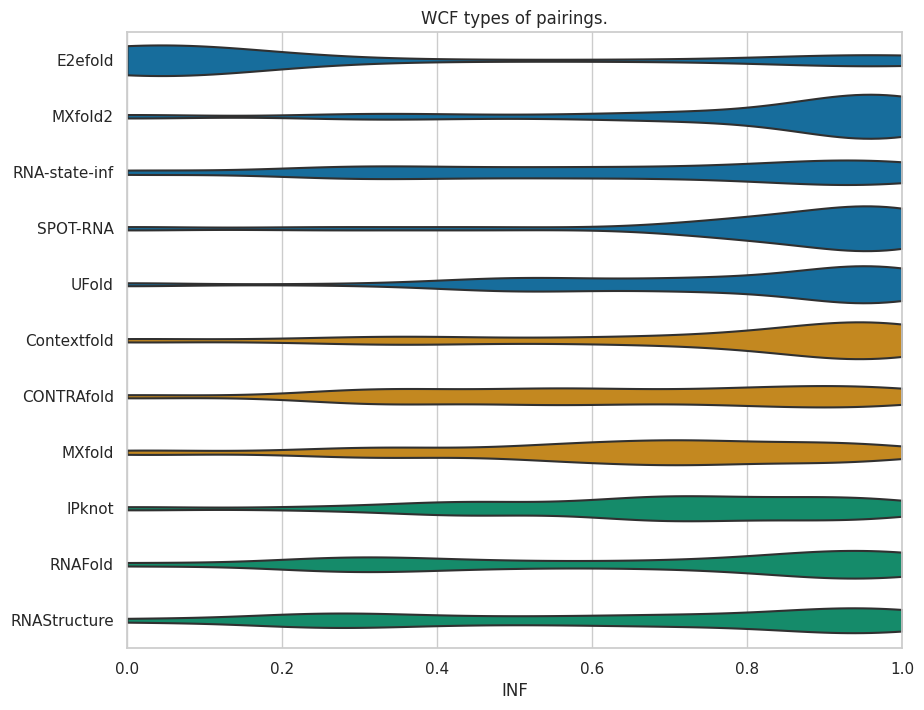

In [19]:
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
from rna2d.pipelines import Results
from rna2d.visualization import Violinplot, SeabornData, get_type_colors
from rna2d.pipelines import RfamNew

colors = get_type_colors()


RFAM142 = "../external-files/rfam-14.2/Rfam.pdb"
RFAM148 = "../external-files/rfam-14.8/Rfam.pdb"
RES_ALL = "/data/2d-rna/new-cifs/validation-all/results.rpt"
RES_WC = "/data/2d-rna/new-cifs/validation-canon/results.rpt"
RES_NWC = "/data/2d-rna/new-cifs/validation-noncanon/results.rpt"
RES_PK = "/data/2d-rna/new-cifs/validation-pseudoknots/results.rpt"
RES_ST = "/data/2d-rna/new-cifs/validation-stack/results.rpt"

ignored_methods = ['spot-rna2', 'rnaalifold', 'rscape', 'turbofold']
rfam_all = RfamNew(RES_ALL, RFAM142, RFAM148, ignored_methods=ignored_methods)
rfam_wc = RfamNew(RES_WC, RFAM142, RFAM148, ignored_methods=ignored_methods)
rfam_nwc = RfamNew(RES_NWC, RFAM142, RFAM148, ignored_methods=ignored_methods)
rfam_pk = RfamNew(RES_PK, RFAM142, RFAM148, ignored_methods=ignored_methods)
rfam_st = RfamNew(RES_ST, RFAM142, RFAM148, ignored_methods=ignored_methods)

filter = []
filter.extend(trpdbs)
filter.extend(homologs)

res_all, ind_all = rfam_all.get_newest_only(filter = filter)
res_wc, ind_wc = rfam_wc.get_newest_only(filter = filter)
res_nwc, ind_nwc = rfam_nwc.get_newest_only(filter = filter)
res_pk, ind_pk = rfam_pk.get_newest_only(filter = filter)
res_st, ind_st = rfam_st.get_newest_only(filter = filter)

order = [
    'e2efold',
    'mxfold2',
    'rna-state-inf',
    'spot-rna',
    'ufold',
    'contextFold',
    'contrafold',
    'mxfold',
    'ipknot',
    'rnafold',
    'rna-structure'
    ]

v = Violinplot()
# sall = SeabornData(res_all, ind_all)
swc = SeabornData(res_wc, ind_wc)
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
# sns_all = sall.get_sns_format_data(order=order, colors_dict=colors)
sns_wc = swc.get_sns_format_data(order=order, colors_dict=colors)
# v.plot(sns_all, axs[0], "A", "All types of pairings.", x_axis=True)
v.plot(sns_wc, axs, "", "WCF types of pairings.", x_axis=True)
fig.savefig("Figure2.eps", format='eps')

In [20]:
from rna2d.utils import get_means_stds, get_DataFrames

with open('../data/test-set-2-ids-all.txt', 'w') as f:
    f.writelines("\n".join(ind_all['spot-rna']))

noncanon_methods = ['spot-rna', 'ufold', 'e2efold']
pk_methods = ['spot-rna', 'e2efold', 'ipknot', 'ufold']

all_means, all_stds, all_dfs = get_means_stds(
    res_all, ind_all, names=True, out_path='../results/all-rfam')
all_dfmeans, all_dfstds = get_DataFrames(
    all_means, all_stds, out_path="../results/all-rfam", name='all')

wc_means, wc_stds, wc_dfs = get_means_stds(
    res_wc, ind_wc, names=True, out_path='../results/canon-rfam')
wc_dfmeans, wc_dfstds = get_DataFrames(
    wc_means, wc_stds, out_path="../results/canon-rfam", name='canon')

nwc_means, nwc_stds, nwc_dfs = get_means_stds(
    res_nwc, ind_nwc, names=True, out_path='../results/noncanon-rfam', selected_methods=noncanon_methods)
nwc_dfmeans, nwc_dfstds = get_DataFrames(
    nwc_means, nwc_stds, out_path="../results/noncanon-rfam", name='noncanon')

pk_means, pk_stds, pk_dfs = get_means_stds(
    res_pk, ind_pk, names=True, out_path='../results/pseudo-rfam', selected_methods=pk_methods)
pk_dfmeans, pk_dfstds = get_DataFrames(
    pk_means, pk_stds, out_path="../results/pseudo-rfam", name='pseudo')

st_means, st_stds, st_dfs = get_means_stds(
    res_st, ind_st, names=True, out_path='../results/stack-rfam')
st_dfmeans, st_dfstds = get_DataFrames(
    st_means, st_stds, out_path="../results/stack-rfam", name='stack')

### New Rfam Families analysis (Rfam 14.8 \ 14.2)

In [41]:
import numpy as np
import pandas as pd
from rna2d.pipelines import Results
from rna2d.utils import get_names

def get_updated_df(path, method = 'rnaalifold', colors_dict: dict = {}):
    results = Results(path, [])
    methods, indeces = results.run_for_all()
    df = pd.DataFrame(methods[method], 
                    columns=['PPV', 'TPR', 'F1', 'INF'],
                    index=indeces[method])
    infs = df['INF'].values
    m = np.full(len(infs), get_names()[method])
    means = np.full(len(infs), np.mean(infs))
    colors = np.full(len(infs), colors_dict.get(method, 0))
    sns_df = pd.DataFrame({"Method": m, "INF": infs, 'Means': means, 'Color': colors})
    return sns_df

MSA_ALL = "/data/2d-rna/validation-msa/results.rpt"
alifold_df = get_updated_df(MSA_ALL, method='rnaalifold', colors_dict=colors)
rscape_df = get_updated_df(MSA_ALL, method='rscape', colors_dict=colors)
turbo_df = get_updated_df(MSA_ALL, method='turbofold', colors_dict=colors)
spot2_df = get_updated_df(RES_WC, method='spot-rna2', colors_dict=colors)
spot2_nwc_df = get_updated_df(RES_NWC, method='spot-rna2', colors_dict=colors)
spot2_pk_df = get_updated_df(RES_PK, method='spot-rna2', colors_dict=colors)
spot2_st_df = get_updated_df(RES_ST, method='spot-rna2', colors_dict=colors)
print(turbo_df)
rearanged_order =  [
    'e2efold',
    'mxfold2',
    'rna-state-inf',
    'spot-rna',
    'spot-rna2',
    'ufold',
    'contextFold',
    'contrafold',
    'mxfold',
    'ipknot',
    'rnaalifold',
    'rnafold',
    'rna-structure'
    ]

rearanged_order = [get_names()[m] for m in rearanged_order]

          Method    INF     Means  Color
0   TurboFold II  0.782  0.580214      2
1   TurboFold II  0.587  0.580214      2
2   TurboFold II  0.905  0.580214      2
3   TurboFold II  0.401  0.580214      2
4   TurboFold II  0.865  0.580214      2
5   TurboFold II  0.737  0.580214      2
6   TurboFold II  0.959  0.580214      2
7   TurboFold II  0.973  0.580214      2
8   TurboFold II  1.000  0.580214      2
9   TurboFold II  0.000  0.580214      2
10  TurboFold II  0.000  0.580214      2
11  TurboFold II  0.000  0.580214      2
12  TurboFold II  0.467  0.580214      2
13  TurboFold II  0.447  0.580214      2


0 spot-rna
1 mxfold2
2 ufold
3 contextFold
4 ipknot
5 contrafold
6 rnafold
7 mxfold
8 rna-state-inf
9 rna-structure
10 e2efold
15


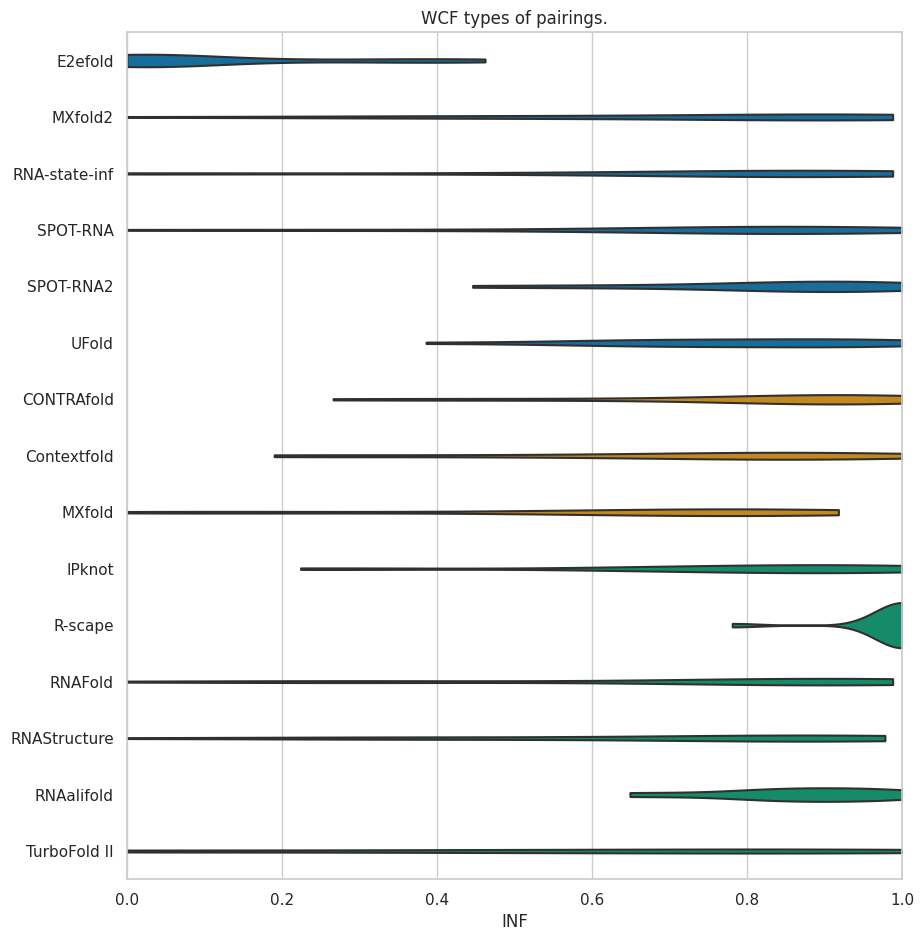

In [49]:
%autoreload 2
from rna2d.utils import get_single_representative


all_novel = {}
all_ind_novel = {}
wc_novel = {}
wc_ind_novel = {}
nwc_novel = {}
nwc_ind_novel = {}
pk_novel = {}
pk_ind_novel = {}
st_novel = {}
st_ind_novel = {}
keys = list(rfam_novel.keys())

ignored_methods = ['rnaalifold', 'spot-rna2', 'rscape', 'turbofold']
rfam_all = RfamNew(RES_ALL, RFAM142, RFAM148, ignored_methods=ignored_methods)
rfam_wc = RfamNew(RES_WC, RFAM142, RFAM148, ignored_methods=ignored_methods)
rfam_nwc = RfamNew(RES_NWC, RFAM142, RFAM148, ignored_methods=ignored_methods)
rfam_pk = RfamNew(RES_PK, RFAM142, RFAM148, ignored_methods=ignored_methods)
rfam_st = RfamNew(RES_ST, RFAM142, RFAM148, ignored_methods=ignored_methods)

res_all, ind_all = rfam_all.get_newest_only(filter = trpdbs)
res_wc, ind_wc = rfam_wc.get_newest_only(filter = trpdbs)
res_nwc, ind_nwc = rfam_nwc.get_newest_only(filter = trpdbs)
res_pk, ind_pk = rfam_pk.get_newest_only(filter = trpdbs)
res_st, ind_st = rfam_st.get_newest_only(filter = trpdbs)


order = [
    'e2efold',
    'mxfold2',
    'rna-state-inf',
    'spot-rna',
    'ufold',
    'contextFold',
    'contrafold',
    'mxfold',
    'ipknot',
    'rnafold',
    'rna-structure'
    ]

single_rep = get_single_representative(
    all_indeces = res_all['spot-rna'].index.tolist(),
    pk_indeces = res_pk['spot-rna'].index.tolist(),
    novel_keys = keys,
    mapping = rfam8_mapping,
    seed=100
    )


keys_all = [k for k in single_rep if k in res_all['spot-rna'].index]
keys_wc = [k for k in single_rep if k in res_wc['spot-rna'].index]
keys_nwc = [k for k in single_rep if k in res_nwc['spot-rna'].index]
keys_pk = [k for k in single_rep if k in res_pk['spot-rna'].index]
keys_st = [k for k in single_rep if k in res_st['spot-rna'].index]


for i, n in enumerate(res_all):
    print(i, n)
    all_novel[n] = res_all[n].loc[keys_all]
    all_ind_novel[n] = keys_all
    wc_novel[n] = res_wc[n].loc[keys_wc]
    wc_ind_novel[n] = keys_wc
    nwc_novel[n] = res_nwc[n].loc[keys_nwc]
    nwc_ind_novel[n] = keys_nwc
    pk_novel[n] = res_pk[n].loc[keys_pk]
    pk_ind_novel[n] = keys_pk
    st_novel[n] = res_st[n].loc[keys_st]
    st_ind_novel[n] = keys_st

# o = [
#     'e2efold',
#     'mxfold2',
#     'rna-state-inf',
#     'spot-rna',
#     "spot-rna2",
#     'ufold',
#     'contextFold',
#     'contrafold',
#     'mxfold',
#     'ipknot',
#     "rscape",
#     "rnaalifold",
#     'rnafold',
#     'rna-structure'
#     ]
# names = [get_names()[m] for m in o]
v = Violinplot()
# sall = SeabornData(all_novel, ind_all)
swc = SeabornData(wc_novel, wc_ind_novel)
# generate a single plot. Create a figure and get axis
fig, axs = plt.subplots(1, 1, figsize=(10, 11))

# sns_all = sall.get_sns_format_data(order=order, colors_dict=colors)
sns_wc = swc.get_sns_format_data(order=order, colors_dict=colors)
sns_wc = pd.concat([sns_wc, alifold_df, spot2_df, rscape_df, turbo_df], axis=0)

# sort dataframe by two columns.
sns_wc = sns_wc.sort_values(by=['Color', "Method"], ascending=[True, True])

v.plot(sns_wc, axs, "", "WCF types of pairings.", x_axis=True)
fig.savefig("Figure3.eps", format='eps')

In [50]:
print(sns_wc.groupby('Method').count())
print(rscape_df.groupby('Method').count())
print(alifold_df.groupby('Method').count())
print("Turbofold")
print(turbo_df.groupby('Method').count())
print(turbo_df.groupby('Method').mean())
print(turbo_df.groupby('Method').std())

               INF  Means  Color
Method                          
CONTRAfold      16     16     16
Contextfold     16     16     16
E2efold         16     16     16
IPknot          16     16     16
MXfold          16     16     16
MXfold2         16     16     16
R-scape         14     14     14
RNA-state-inf   16     16     16
RNAFold         16     16     16
RNAStructure    16     16     16
RNAalifold      14     14     14
SPOT-RNA        16     16     16
SPOT-RNA2       13     13     13
TurboFold II    14     14     14
UFold           16     16     16
         INF  Means  Color
Method                    
R-scape   14     14     14
            INF  Means  Color
Method                       
RNAalifold   14     14     14
              INF  Means  Color
Method                         
TurboFold II   14     14     14


In [16]:
from rna2d.utils import get_means_stds, get_DataFrames
with open('../data/test-set-3-ids-all.txt', 'w') as f:
    f.writelines("\n".join(keys_all))

with open('../data/test-set-3-ids-fams.txt', 'w') as f:
    for k in keys_all:
        f.write(f"{k} {rfam8_mapping[k]}\n")

noncanon_methods = ['spot-rna', 'spot-rna2', 'ufold', 'e2efold']
pk_methods = ['spot-rna', 'spot-rna2', 'e2efold', 'ipknot', 'ufold']
# Novel

all_means, all_stds, all_dfs = get_means_stds(
    all_novel, all_ind_novel, names=True, out_path='../results/all-novel')
all_dfmeans, all_dfstds = get_DataFrames(
    all_means, all_stds, out_path="../results/all-novel", name='all')

wc_means, wc_stds, wc_dfs = get_means_stds(
    wc_novel, wc_ind_novel, names=True, out_path='../results/canon-novel')
wc_dfmeans, wc_dfstds = get_DataFrames(
    wc_means, wc_stds, out_path="../results/canon-novel", name='canon')

nwc_means, nwc_stds, nwc_dfs = get_means_stds(
    nwc_novel, nwc_ind_novel, names=True, out_path='../results/noncanon-novel', selected_methods=noncanon_methods)
nwc_dfmeans, nwc_dfstds = get_DataFrames(
    nwc_means, nwc_stds, out_path="../results/noncanon-novel", name='noncanon')

pk_means, pk_stds, pk_dfs = get_means_stds(
    pk_novel, pk_ind_novel, names=True, out_path='../results/pseudo-novel', selected_methods=pk_methods)
pk_dfmeans, pk_dfstds = get_DataFrames(
    pk_means, pk_stds, out_path="../results/pseudo-novel", name='pseudo')

st_means, st_stds, st_dfs = get_means_stds(
    st_novel, st_ind_novel, names=True, out_path='../results/stack-novel')
st_dfmeans, st_dfstds = get_DataFrames(
    st_means, st_stds, out_path="../results/stack-novel", name='stack')


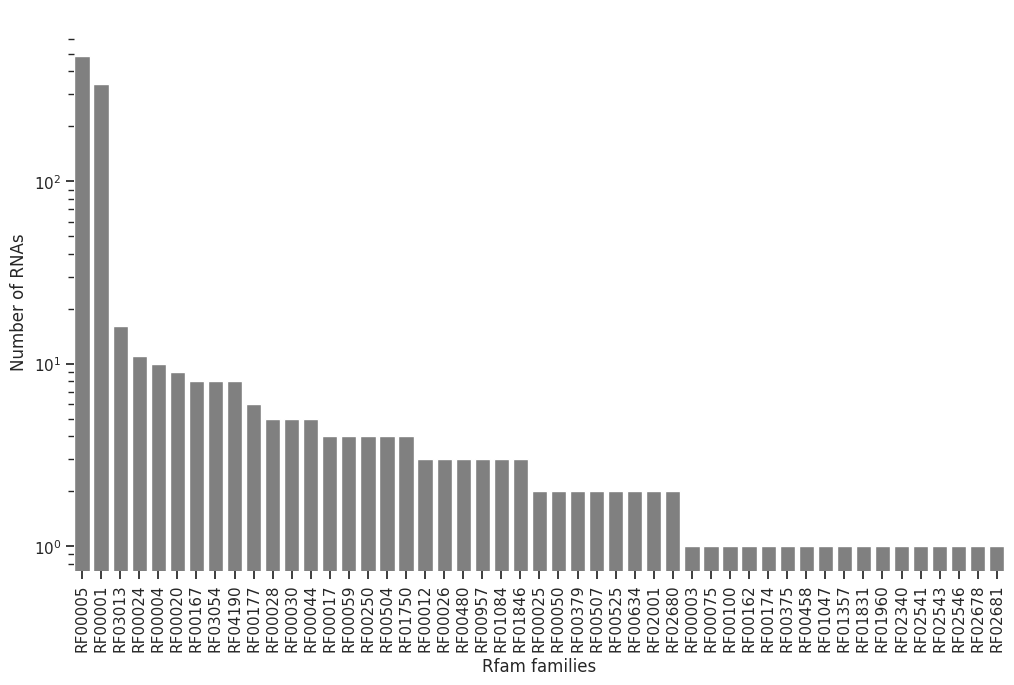

In [21]:
from collections import Counter
import matplotlib.pyplot as plt

new_seq_ids = res_all['spot-rna'].index.tolist()
new_seq_ids = [new_mapping[p] for p in new_seq_ids]

c = Counter(new_seq_ids)
vals = list(c.values())
keys = list(c.keys())

vk = sorted(zip(keys, vals), key=lambda x : (-x[1], x[0]), reverse=False)
rest = vk[2:]
skeys = [x[0] for x in vk]
svals = [x[1] for x in vk]
rkeys = [x[0] for x in rest]
rvals = [x[1] for x in rest]


def plot_representatives(keys, vals, title, scale = None, rotate=True, frame = False):
    fig, ax = plt.subplots(figsize=(12,7))
    ax.grid(True, 'both', zorder=0)
    ax.bar(keys, vals, color='gray', zorder=3, log=True)

    if rotate:
        _ = plt.xticks(rotation=90)
    plt.margins(x=0)
    
    # remove gridlines
    ax.grid(False)
    plt.grid(False, which="both")

    # make ticks visible on axes x and y
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('left')

    if title != "":
        plt.xlabel("Rfam families")
        plt.ylabel("Number of RNAs")
        plt.title(title)
        
    if scale is not None:
        plt.yticks(scale)
    if not frame:
        for pos in ['right', 'top', 'bottom', 'left']:
            plt.gca().spines[pos].set_visible(False)

plot_representatives(skeys, svals, title=" ",)
# plot_representatives(rkeys, rvals, title="", scale = range(0, max(rvals), 2), frame=True)

In [18]:
print(len(all_dfs['SPOT-RNA']))
print(len(wc_dfs['SPOT-RNA']))
print(len(nwc_dfs['SPOT-RNA']))
print(len(pk_dfs['SPOT-RNA']))

print(len(all_dfs['SPOT-RNA']))
print(len(wc_dfs['SPOT-RNA']))
print(len(nwc_dfs['SPOT-RNA']))
print(len(pk_dfs['SPOT-RNA']))

16
16
16
5
16
16
16
5


In [19]:
pk_dfmeans

,PPV,TPR,F1,INF
SPOT-RNA,0.2,0.2,0.20,0.20
UFold,0.4,0.4,0.40,0.40
IPknot,0.0,0.0,0.00,0.00
E2efold,0.1,0.2,0.13,0.14


In [20]:
pk_dfstds

,PPV,TPR,F1,INF
SPOT-RNA,0.45,0.45,0.45,0.45
UFold,0.55,0.55,0.55,0.55
IPknot,0.00,0.00,0.00,0.00
E2efold,0.22,0.45,0.30,0.32
